# Instrument Family Classification

## Data Preprocessing


In [10]:
import os
import json
import random
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Load JSON metadata
with open('../data/examples.json', 'r') as f:
    metadata = json.load(f)

# Define the folder containing audio files
audio_dir = '../data/audio'

# List all .wav files in the audio directory
audio_filenames = set(f.replace('.wav', '') for f in os.listdir(audio_dir) if f.endswith('.wav'))

# Filter JSON entries to only those with matching audio files
matched_entries = {
    key: value for key, value in metadata.items() if key in audio_filenames
}

# Count how many matched entries we have
print(f"Matched {len(matched_entries)} audio files with metadata.")

# Count the class distribution in 'instrument_family_str'
family_counter = Counter(entry['instrument_family_str'] for entry in matched_entries.values())

# Display unique classes and their counts
print("Class distribution in instrument_family_str:")
for family, count in family_counter.items():
    print(f"  {family}: {count}")

# Get a mapping for class labels
family_to_label = {name: i for i, name in enumerate(sorted(family_counter))}
label_to_family = {i: name for name, i in family_to_label.items()}

print("\nClass label mapping:")
print(family_to_label)

# Number of classes
num_classes = len(family_to_label)
print(f"Number of classes: {num_classes}")

Matched 4096 audio files with metadata.
Class distribution in instrument_family_str:
  bass: 843
  keyboard: 766
  guitar: 652
  reed: 235
  flute: 180
  string: 306
  vocal: 141
  brass: 269
  mallet: 202
  organ: 502

Class label mapping:
{'bass': 0, 'brass': 1, 'flute': 2, 'guitar': 3, 'keyboard': 4, 'mallet': 5, 'organ': 6, 'reed': 7, 'string': 8, 'vocal': 9}
Number of classes: 10


In [11]:
# Set seed for reproducibility
random.seed(6600)

# Create a list of matched (key, label) pairs
all_data = [(key, family_to_label[meta["instrument_family_str"]])
            for key, meta in matched_entries.items()]

# Prepare data for splitting
X = [key for key, _ in all_data]
y = [label for _, label in all_data]

# First split: Train vs Temp(Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=6688)

# Second split: Val vs Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=6600)

# Re-create data tuples for our dataset classes
train = list(zip(X_train, y_train))
val = list(zip(X_val, y_val))
test = list(zip(X_test, y_test))

print(f"Train: {len(train)}  Val: {len(val)}  Test: {len(test)}")

# Check class distribution in each split
train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

print("\nClass distribution in train set:")
for label, count in sorted(train_dist.items()):
    print(f"  {label_to_family[label]}: {count}")

print("\nClass distribution in validation set:")
for label, count in sorted(val_dist.items()):
    print(f"  {label_to_family[label]}: {count}")

print("\nClass distribution in test set:")
for label, count in sorted(test_dist.items()):
    print(f"  {label_to_family[label]}: {count}")

Train: 2457  Val: 819  Test: 820

Class distribution in train set:
  bass: 521
  brass: 147
  flute: 94
  guitar: 388
  keyboard: 470
  mallet: 126
  organ: 306
  reed: 140
  string: 189
  vocal: 76

Class distribution in validation set:
  bass: 142
  brass: 70
  flute: 45
  guitar: 130
  keyboard: 149
  mallet: 30
  organ: 102
  reed: 52
  string: 61
  vocal: 38

Class distribution in test set:
  bass: 180
  brass: 52
  flute: 41
  guitar: 134
  keyboard: 147
  mallet: 46
  organ: 94
  reed: 43
  string: 56
  vocal: 27


## Dataset and Dataloader


In [12]:
class NSynthWaveformDataset(Dataset):
    def __init__(self, data_list, json_data, audio_dir, transform=None):
        self.data_list = data_list
        self.json_data = json_data
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        key, label = self.data_list[idx]
        path = os.path.join(self.audio_dir, f"{key}.wav")
        
        waveform, sr = librosa.load(path, sr=16000)
        waveform = torch.tensor(waveform).unsqueeze(0)  # [1, 64000]
        
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, label


# Create Dataloaders
batch_size = 16

train_ds = NSynthWaveformDataset(train, metadata, audio_dir)
val_ds = NSynthWaveformDataset(val, metadata, audio_dir)
test_ds = NSynthWaveformDataset(test, metadata, audio_dir)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Model Architecture - 1D CNN


In [13]:
class InstrumentFamilyCNN(nn.Module):
    def __init__(self, input_length=64000, n_classes=10):
        super(InstrumentFamilyCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        
        # Calculate output size after conv layers
        dummy_input = torch.zeros(1, 1, input_length)
        out = self.conv_layers(dummy_input)
        flattened_size = out.shape[1] * out.shape[2]
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstrumentFamilyCNN(n_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Training and Evaluation


In [14]:
def train_epoch(model, loader):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        all_preds.append(preds.argmax(dim=1).cpu())
        all_labels.append(y.cpu())
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    return avg_loss, acc

def eval_epoch(model, loader):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)

            total_loss += loss.item() * x.size(0)
            all_preds.append(preds.argmax(dim=1).cpu())
            all_labels.append(y.cpu())
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    return avg_loss, acc, torch.cat(all_preds), torch.cat(all_labels)

# Training Loop with Early Stopping
num_epochs = 25
patience = 5  # Stop after 5 epochs without improvement
best_val_loss = float('inf')
counter = 0  # Counter for epochs without improvement
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/25 | Train Loss: 2.1399, Acc: 0.289 | Val Loss: 1.5216, Acc: 0.405
Epoch 2/25 | Train Loss: 1.6485, Acc: 0.366 | Val Loss: 1.5012, Acc: 0.416
Epoch 3/25 | Train Loss: 1.5285, Acc: 0.404 | Val Loss: 1.3563, Acc: 0.452
Epoch 4/25 | Train Loss: 1.3828, Acc: 0.465 | Val Loss: 1.2093, Acc: 0.547
Epoch 5/25 | Train Loss: 1.2432, Acc: 0.510 | Val Loss: 1.0819, Acc: 0.586
Epoch 6/25 | Train Loss: 1.1370, Acc: 0.553 | Val Loss: 1.0195, Acc: 0.608
Epoch 7/25 | Train Loss: 1.0515, Acc: 0.584 | Val Loss: 0.8768, Acc: 0.646
Epoch 8/25 | Train Loss: 0.9840, Acc: 0.590 | Val Loss: 0.8698, Acc: 0.650
Epoch 9/25 | Train Loss: 0.9034, Acc: 0.622 | Val Loss: 0.7221, Acc: 0.717
Epoch 10/25 | Train Loss: 0.8191, Acc: 0.660 | Val Loss: 0.6384, Acc: 0.730
Epoch 11/25 | Train Loss: 0.7399, Acc: 0.697 | Val Loss: 0.6892, Acc: 0.745
Epoch 12/25 | Train Loss: 0.7339, Acc: 0.711 | Val Loss: 0.5221, Acc: 0.813
Epoch 13/25 | Train Loss: 0.6737, Acc: 0.734 | Val Loss: 0.5461, Acc: 0.769
Epoch 14/25 | Train L

## Results Visualization


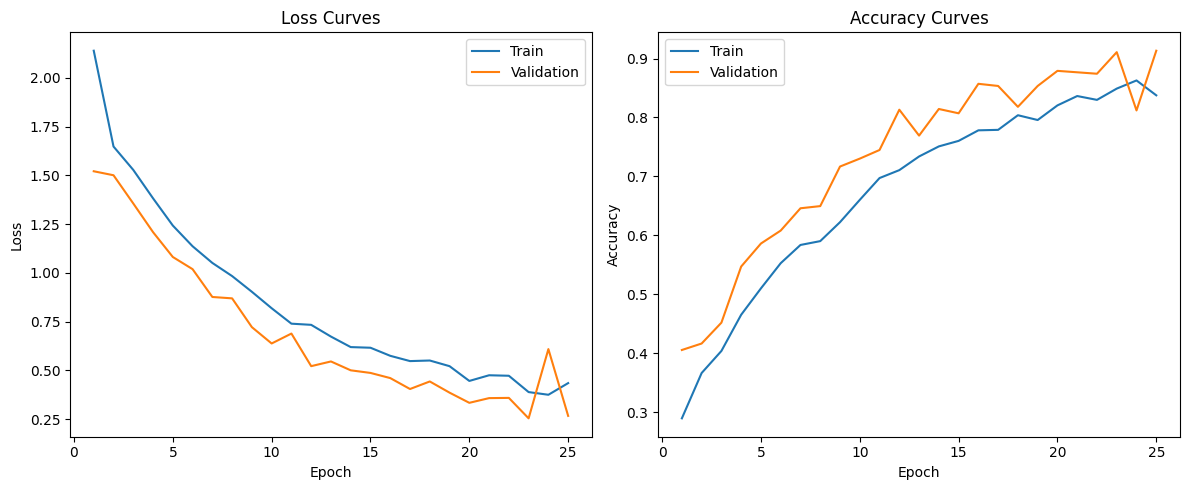

Loading best model for evaluation...
Test Loss: 0.2481, Test Accuracy: 0.9085


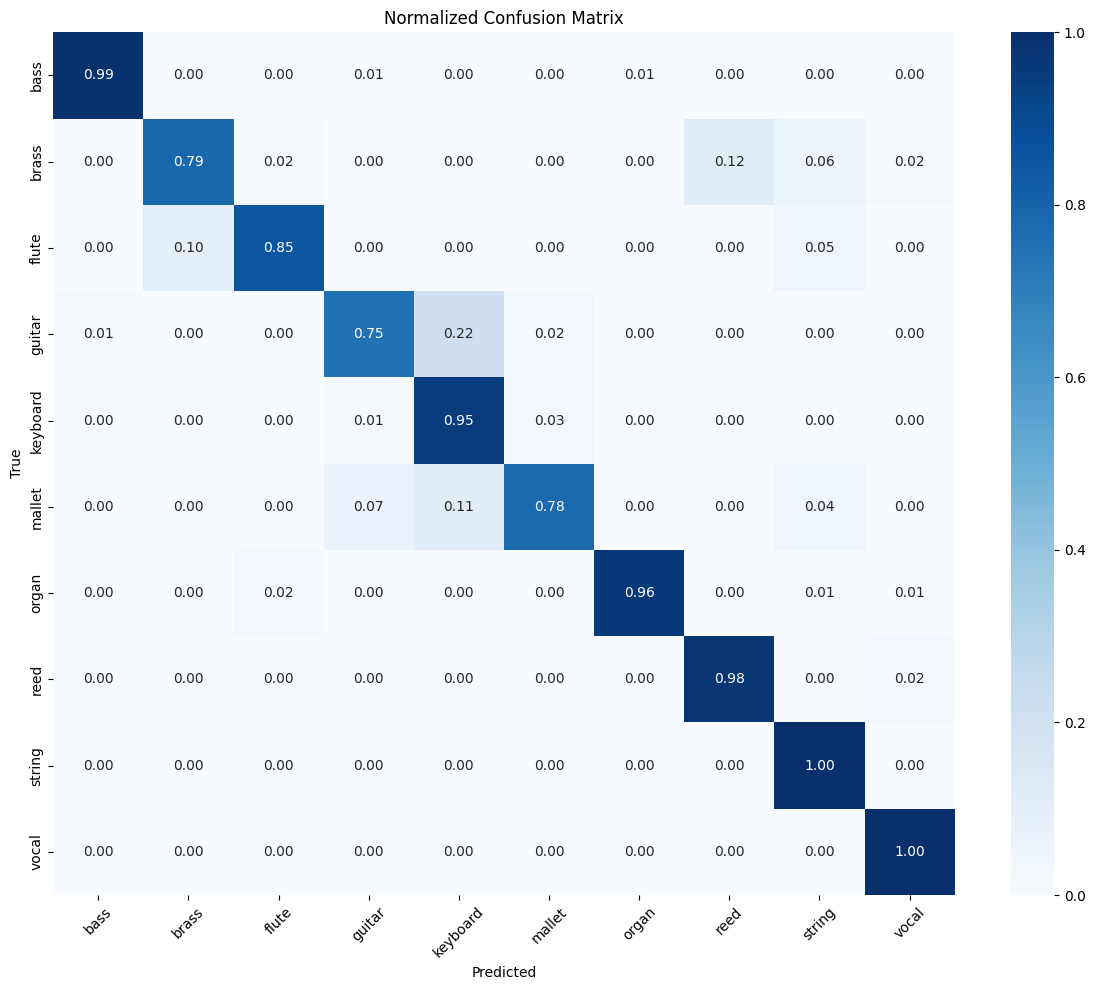

Classification Report:
              precision    recall  f1-score   support

        bass       0.99      0.99      0.99       180
       brass       0.91      0.79      0.85        52
       flute       0.92      0.85      0.89        41
      guitar       0.94      0.75      0.83       134
    keyboard       0.80      0.95      0.87       147
      mallet       0.82      0.78      0.80        46
       organ       0.99      0.96      0.97        94
        reed       0.88      0.98      0.92        43
      string       0.88      1.00      0.93        56
       vocal       0.90      1.00      0.95        27

    accuracy                           0.91       820
   macro avg       0.90      0.90      0.90       820
weighted avg       0.91      0.91      0.91       820



In [18]:
import warnings
warnings.filterwarnings('ignore')

# Plot with the number of completed epochs
actual_epochs = len(train_losses)  

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, actual_epochs+1), train_losses, label="Train")
plt.plot(range(1, actual_epochs+1), val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, actual_epochs+1), train_accs, label="Train")
plt.plot(range(1, actual_epochs+1), val_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.tight_layout()
plt.show()

# Load best model before evaluation
print("Loading best model for evaluation...")
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on Test Set
test_loss, test_acc, y_pred, y_true = eval_epoch(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[label_to_family[i] for i in range(num_classes)],
            yticklabels=[label_to_family[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=[label_to_family[i] for i in range(num_classes)]))


## Model Saving and Prediction

In [19]:
import shutil
shutil.copy("best_model.pth", "instrument_family_classifier.pth")
print("Best model saved as 'instrument_family_classifier.pth'")

def predict_instrument_family(audio_path, model, family_mapping):
    model.eval()
    waveform, sr = librosa.load(audio_path, sr=16000)
    if len(waveform) > 64000:
        waveform = waveform[:64000]
    elif len(waveform) < 64000:
        waveform = np.pad(waveform, (0, 64000 - len(waveform)))
    
    waveform = torch.tensor(waveform).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = F.softmax(outputs, dim=1)[0]
        predicted_class = outputs.argmax(dim=1).item()
    
    predicted_family = family_mapping[predicted_class]
    probs_dict = {family_mapping[i]: prob.item() for i, prob in enumerate(probabilities)}
    
    return predicted_family, probs_dict

Best model saved as 'instrument_family_classifier.pth'


## Conclusion

We implemented a deeper 1D CNN to classify audio samples into 10 distinct instrument families, including bass, keyboard, guitar, and vocal. The model architecture extended the 3-block CNN used for source classification by adding a fourth convolutional block and expanding the fully connected layers to enhance its capacity to capture complex, hierarchical patterns in raw waveforms. Training was conducted with early stopping based on validation loss, using cross-entropy as the objective function.

After 25 epochs of training, the model achieved a test accuracy of 90.85%. The training and validation accuracy curves show consistent and steady improvement, with no signs of overfitting. The confusion matrix indicates strong performance across most instrument families, with especially high accuracy on vocal, string, and bass classes. Minor confusion was observed between related families, such as guitar and keyboard, or mallet and flute, likely due to similar temporal and spectral characteristics.

These results validate the effectiveness of 1D CNNs in capturing waveform-based patterns for multi-class instrument recognition. The normalized confusion matrix further reveals the model’s robustness across unbalanced class distributions, achieving high precision and recall in underrepresented categories like vocal and reed.